# Multimodal Data Models

MRI and ECG data from UK Biobank:
catalog accession ids are GCST90250896 (for
cross-modal ECG and cardiac MRI unsupervised GWAS)

## Download Data

In [ ]:
!pip install opendatasets
!pip install kaggle

Mount google drive to save Kaggle API credentials

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# kaggle api key
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp /content/drive/MyDrive/Columbia/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download khyeh0719/ptb-xl-dataset

ptb-xl-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip /content/ptb-xl-dataset.zip

Archive:  /content/ptb-xl-dataset.zip
replace ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/LICENSE.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Unpack Data

In [ ]:
! pip install wfdb

In [34]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import wfdb
import ast
from collections import Counter

In [ ]:
! cd /content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1

In [35]:
df = pd.read_csv("/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv")

In [36]:
df = df.drop(['nurse', 'site', 'device', 'recording_date', 'report',
              'heart_axis', 'infarction_stadium1', 'infarction_stadium2', 'validated_by',
              'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
              'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
              'extra_beats', 'pacemaker', 'strat_fold'], axis=1)

In [37]:
numerical_cols = df.select_dtypes(include=[np.number]).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

In [38]:
df["scp_code"] = [s[s.find("'")+1:s.find("'", s.find("'")+2)] for s in df['scp_codes']]

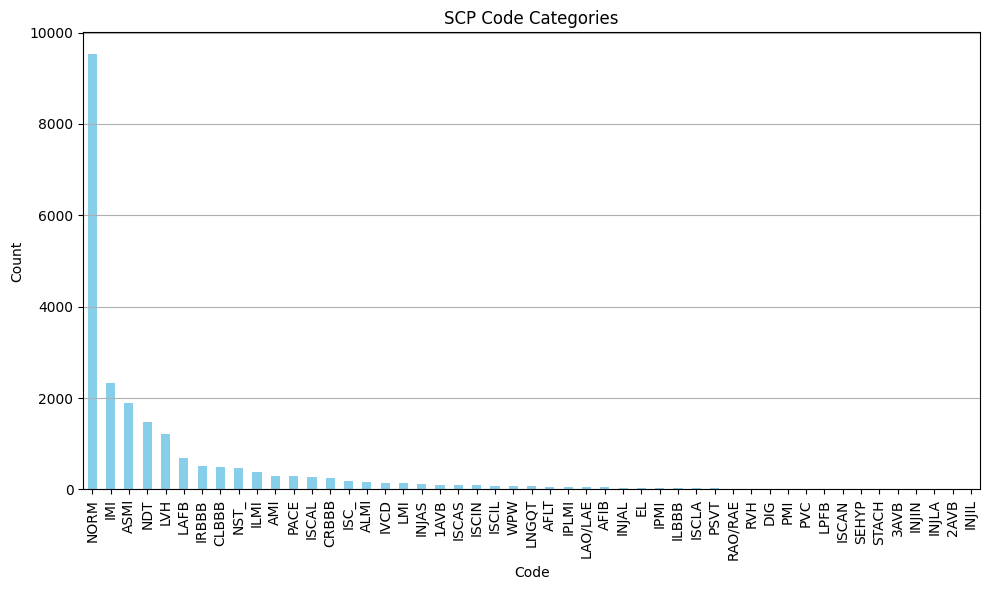

In [39]:
scp_code_values = df["scp_code"].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
scp_code_values.plot(kind='bar', color='skyblue')
plt.title('SCP Code Categories')
plt.xlabel('Code')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis='y')

# Show plot
plt.tight_layout()
plt.show()


In [40]:
df.head()

,ecg_id,patient_id,age,sex,height,weight,scp_codes,filename_lr,filename_hr,scp_code
0,1,15709.0,56.0,1,166.708292,63.0,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",records100/00000/00001_lr,records500/00000/00001_hr,NORM
1,2,13243.0,19.0,0,166.708292,70.0,"{'NORM': 80.0, 'SBRAD': 0.0}",records100/00000/00002_lr,records500/00000/00002_hr,NORM
2,3,20372.0,37.0,1,166.708292,69.0,"{'NORM': 100.0, 'SR': 0.0}",records100/00000/00003_lr,records500/00000/00003_hr,NORM
3,4,17014.0,24.0,0,166.708292,82.0,"{'NORM': 100.0, 'SR': 0.0}",records100/00000/00004_lr,records500/00000/00004_hr,NORM
4,5,17448.0,19.0,1,166.708292,70.0,"{'NORM': 100.0, 'SR': 0.0}",records100/00000/00005_lr,records500/00000/00005_hr,NORM


## Multimodal data representation

Input data:
- age
- sex
- height
- weight
- ECG compressed signals (raw signal data in .hea form - both low res and high res form available. In this model, we use the low res form because of computing constraints)

Output data:
- SCP Code

In [41]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras import layers, models

# for more specific training
import numpy as np
import torch
import torch.nn as nn

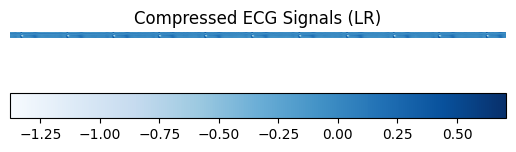

In [42]:
# Example data
fpath = "/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records100/00000/00001_lr"
data_lr = wfdb.rdsamp(fpath)

plt.imshow(data_lr[0].T, cmap='Blues')  # Use 'gray' colormap for grayscale images
cbar = plt.colorbar(orientation='horizontal')  # Add colorbar to show color scale
plt.title('Compressed ECG Signals (LR)')
plt.axis('off')  # Hide axis
plt.show()

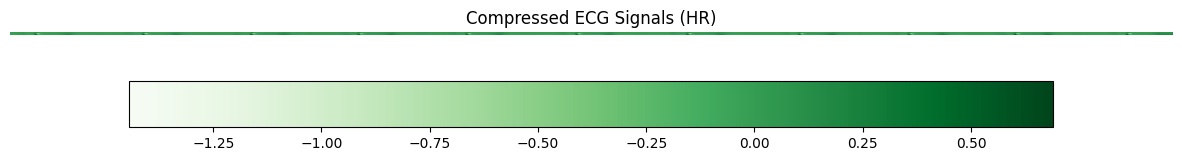

In [43]:
fpath = "/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/00000/00001_hr"
data_hr = wfdb.rdsamp(fpath)

plt.figure(figsize=(15, 4))

plt.imshow(data_hr[0].T, cmap='Greens')  # Use 'gray' colormap for grayscale images
cbar = plt.colorbar(orientation='horizontal')  # Add colorbar to show color scale
plt.title('Compressed ECG Signals (HR)')
plt.axis('off')  # Hide axis
plt.show()

In [44]:
print("Low res data signals: ", str(data_lr[0].shape),
      "\nHigh res data signals: ", str(data_hr[0].shape))

Low res data signals:  (1000, 12) 
High res data signals:  (5000, 12)


In [45]:
ecg_lr_path = ["/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/" + str(fn) for fn in df["filename_lr"]]

ecg_lr_data = [wfdb.rdsamp(fp)[0] for fp in ecg_lr_path]

In [46]:
ehr_columns = ['age', 'sex', 'height', 'weight']
ehr_data = df[ehr_columns].to_numpy()

In [47]:
ecg_lr_data_np = np.array(ecg_lr_data)

In [48]:
# ecg_hr_path = ["/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/" + str(fn) for fn in df["filename_hr"]]

# ecg_hr_data = np.array([wfdb.rdsamp(fp)[0] for fp in ecg_hr_path])

In [49]:
scp_code_labels = {}
labels_scp_code = {}
i=0
for code in df['scp_code'].unique():
  scp_code_labels[code] = i
  labels_scp_code[i] = code
  i+=1

In [50]:
# convert codes to numerical values
scp_data = np.array([scp_code_labels[code] for code in df['scp_code']])

In [51]:
n = ecg_lr_data_np.shape[0]
train_n = int(0.8*n)
val_n = int(0.9*n) # goes up to this amount
test_n = int(n - train_n)

In [52]:
# separate into training and testing data

# for training
x_train_ecg = ecg_lr_data_np[:train_n, :, :]  # first 80% images
x_train_ehr = ehr_data[:train_n] # first 80% records
y_train_scp = scp_data[:train_n] # first 80% scp codes (desired output)

#for validation (next 10%. last 10% reserved for testing)
x_val_ecg = ecg_lr_data_np[train_n+1:val_n, :, :]
x_val_ehr = ehr_data[train_n+1:val_n]
y_val_scp = scp_data[train_n+1:val_n]

## Model Training (Low res ECG)

In [53]:
# input layers for image and unclean label
ecg_input = tf.keras.layers.Input(shape=(1000, 12), name='ecg_input') #low res ecg
ehr_input = tf.keras.layers.Input(shape=(4,), name='ehr_input')

# cnn for image
# conv1 = tf.keras.layers.Conv2D(1000, (3, 3), activation='relu', padding='same')(ecg_input)
# conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
# pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

# conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
# conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
# pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)
conv1 = tf.keras.layers.Conv1D(100, 3, activation='relu', padding='same')(ecg_input)
conv2 = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(conv1)
pool1 = tf.keras.layers.MaxPooling1D(2)(conv2)

conv3 = tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same')(pool1)
conv4 = tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same')(conv3)
pool2 = tf.keras.layers.MaxPooling1D(2)(conv4)

# Flatten the pooled features
flattened_pool = tf.keras.layers.Flatten()(pool2)

# Concatenate flattened image and unclean label inputs
concatenated_inputs = tf.keras.layers.Concatenate()([flattened_pool, ehr_input])

# Add dropout for regularization
dropout1 = tf.keras.layers.Dropout(0.25)(concatenated_inputs)

# Dense layers for feature extraction
dense1 = tf.keras.layers.Dense(256, activation='relu')(dropout1)
dense2 = tf.keras.layers.Dense(128, activation='relu')(dense1)

# Add dropout for regularization
dropout2 = tf.keras.layers.Dropout(0.5)(dense2)

# Output layer
output = tf.keras.layers.Dense(10, activation='softmax', name='output')(dropout2)

# Define the model with multiple inputs
model = tf.keras.models.Model(inputs=[ecg_input, ehr_input], outputs=output)

# Compile the model
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ecg_input (InputLayer)      [(None, 1000, 12)]           0         []                            
                                                                                                  
 conv1d_4 (Conv1D)           (None, 1000, 100)            3700      ['ecg_input[0][0]']           
                                                                                                  
 conv1d_5 (Conv1D)           (None, 1000, 64)             19264     ['conv1d_4[0][0]']            
                                                                                                  
 max_pooling1d_2 (MaxPoolin  (None, 500, 64)              0         ['conv1d_5[0][0]']            
 g1D)                                                                                       

In [1]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.0001, restore_best_weights=True)
learning_rate_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)

# Train the model
history_model1 = model.fit([x_train_ecg,x_train_ehr], y_train_scp, epochs=50,
                          validation_data=([x_val_ecg, x_val_ehr], y_val_scp),
                                   callbacks=[early_stopping, learning_rate_scheduler])

# Evaluate the model
test_loss, test_acc = model.evaluate([x_val_ecg, x_val_ehr], y_val_scp)
print('Test accuracy:', test_acc)

NameError: name 'tf' is not defined

### Visualizations for Model 1

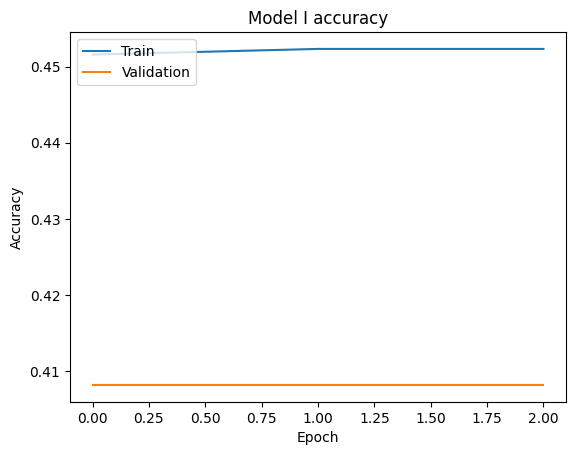

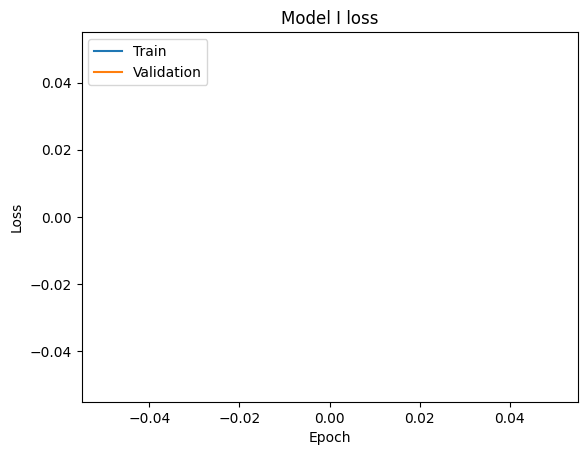

In [55]:
## Accuracy and Loss

# Plot training & validation accuracy values
plt.plot(history_model1.history['accuracy'])
plt.plot(history_model1.history['val_accuracy'])
plt.title('Model I accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_model1.history['loss'])
plt.plot(history_model1.history['val_loss'])
plt.title('Model I loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Model 2 (Low res ECG)

Tried with high res ecg signals and it just kept crashing my RAM

In [ ]:
model.save("model1.h5")
np.save('ecg_lr_data_np.npy', ecg_lr_data_np)